# Self-Supervised Vision Transformer for Land Cover Segmentation: Swin Transformer + Sentinel-1/2

This notebook is an adaptation of a demo originally presented by Linus Scheibenreif, Joëlle Hanna, at the [University of St.Gallen, School of Computer Science, AIML Lab](https://ics.unisg.ch/chair-aiml-borth/). Originally designed for a classification task, this notebook has been modified for a segmentation task.

The notebook contains code for fine-tuning pretrained Swin Transformer backbones as introduced in their work. It utilizes two backbones, one processing Sentinel-1 SAR data and the other handling Sentinel-2 multi-band imagery. These backbones are combined to address the segmentation task. In this example, we aim to fine-tune the Swin Transformer backbones for an image segmentation task, using both Sentinel-1 and Sentinel-2 data from the DFC2020 dataset.

This implementation is based on the paper:

[Linus Scheibenreif, Joëlle Hanna, Michael Mommert, Damian Borth, *Self-Supervised Vision Transformers for Land-Cover Segmentation and Classification*, Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR) Workshops, 2022, pp. 1422-1431](https://openaccess.thecvf.com/content/CVPR2022W/EarthVision/html/Scheibenreif_Self-Supervised_Vision_Transformers_for_Land-Cover_Segmentation_and_Classification_CVPRW_2022_paper.html)

## Content

1. [Installation](#installation)
1. [Dataset](#dataset)
1. [Quick Start](#quickstart)

<a id='installation'></a>
## 1. Installation

#### Dependencies

This project uses Python 3.8, and the dependencies listed in `requirements.txt` can be installed with `pip` or `conda`, in a virtual environment. For example, using `pip`:


In [ ]:
'''!pip install albumentations==1.1.0
!pip install apex==0.1
!pip install diffdist==0.1
!pip install matplotlib==3.5.0
!pip install numpy==1.21.4
!pip install pandas==1.3.4
!pip install rasterio==1.2.10
!pip install termcolor==1.1.0
!pip install timm.egg==info
!pip install torch==1.11.0a0+b6df043
!pip install torchvision==0.11.0a0
!pip install tqdm==4.62.3 '''

In [2]:
# Import needed packages
import argparse
import json
import os
import random
import numpy as np
import torch
import wandb
import torch.nn.functional as F
from distutils.util import strtobool
from tqdm import tqdm
from torchvision.models import resnet18, resnet50

<a id='dataset'></a>
## 2. Dataset


#### Download

 In this notebook, we will use the DFC2020 dataset to train downstream tasks. You can download it using this [link](https://ieee-dataport.org/competitions/2020-ieee-grss-data-fusion-contest). We are using multimodal input here (fusion of Sentinel-1 and Sentinel-2)


#### Configure 

For example, in the `data_config` dictionary (cell below), you can specify paths to the data directory with `train_dir` and `val_dir` or the image input size with `image_px_size`.

In [4]:
# Data configurations:
data_config = {
    'train_dir': 'C:\\Users\\frank\\Desktop\\data sentinel\\train', # path to the training directory,  
    'val_dir': 'C:\\Users\\frank\\Desktop\\data sentinel\\val', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 8, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

In [3]:
# Ensure deterministic behavior
import random
import numpy as np

random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

#### Prepare

We create the `train_dataset` and `val_dataset` by using the `DFCDataset`, a custom class of `torch.utils.data.Dataset`

In [8]:
from dfc_dataset import DFCDataset

# Create Training Dataset
train_dataset = DFCDataset(
    data_config['train_dir'],
    mode=data_config['train_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['train_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_train'],
    seed=data_config['seed']
)

# Create Validation Dataset
val_dataset = DFCDataset(
    data_config['val_dir'],
    mode=data_config['val_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['val_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_validation'],
    seed=data_config['seed']
)

We can see how many examples are in each split by checking their length:

In [11]:
len(train_dataset), len(val_dataset)

(986, 5128)

We can also display some examples:

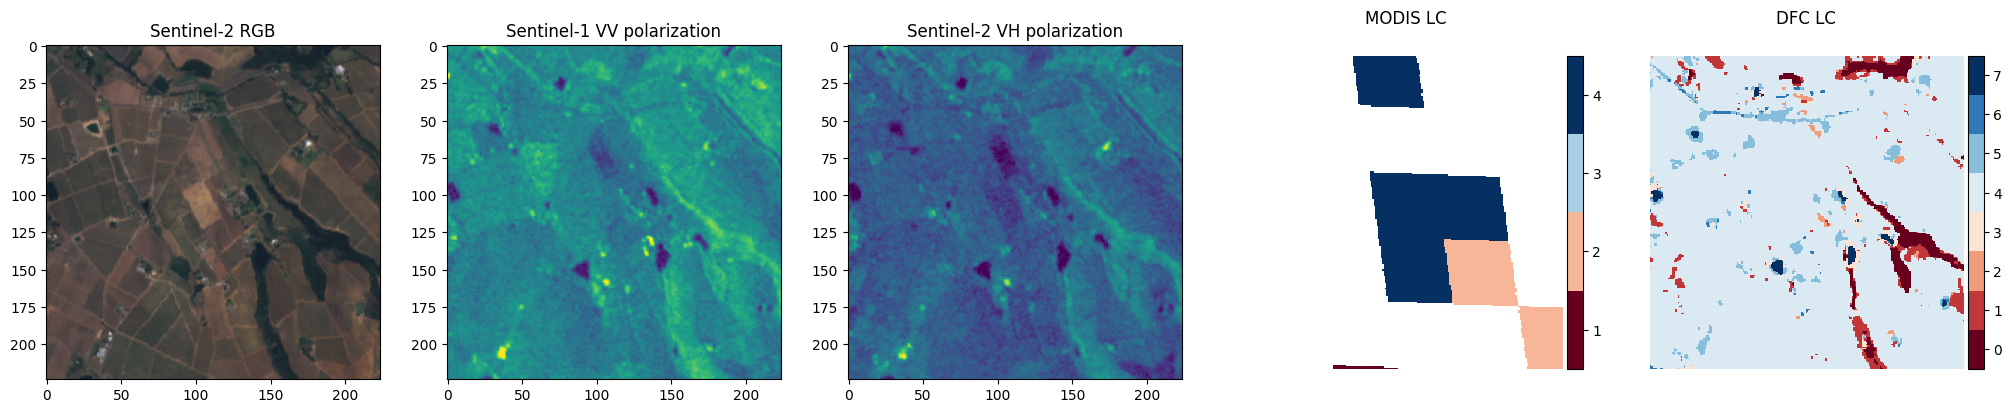

In [13]:
train_dataset.visualize_observation(67)

The plots show, from left to right: Sentinel-2 true color image, Sentinel-1 maps for the two different polarizations, a coarse MODIS LULC map and the high-resolution DFC2020 LULC map.

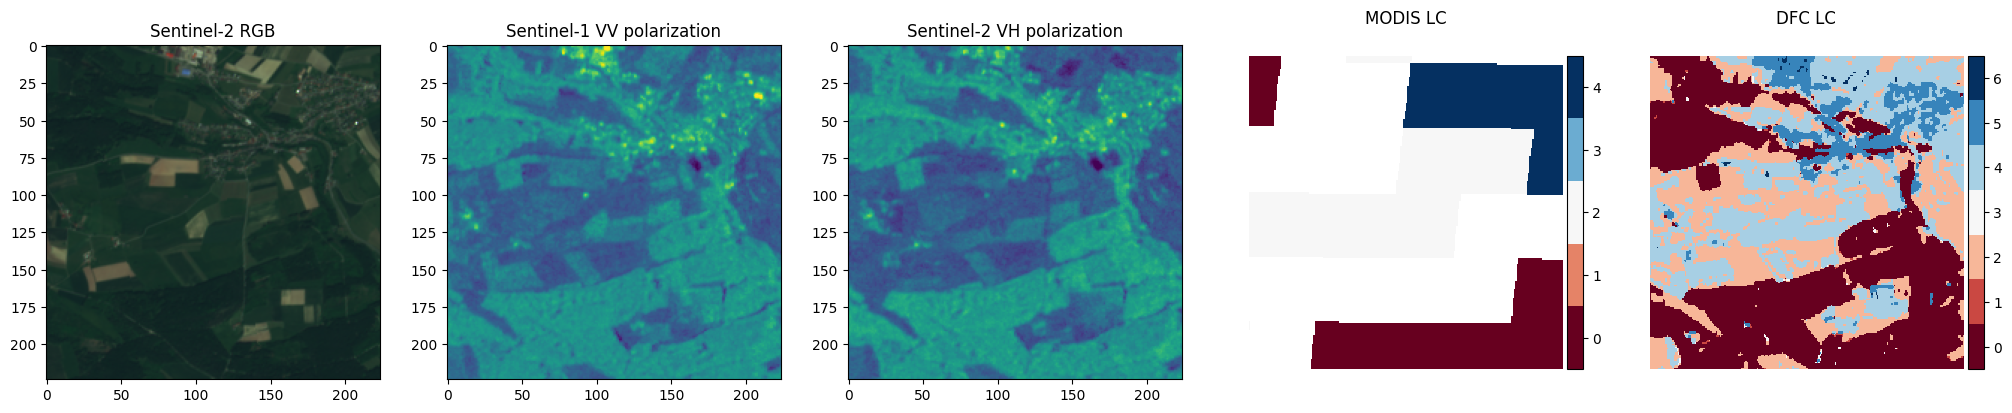

In [15]:
val_dataset.visualize_observation(89)

We define a correspondance of label and names:

In [10]:
DFC_map_clean = {
    0: "Forest",
    1: "Shrubland",
    2: "Grassland",
    3: "Wetlands",
    4: "Croplands",
    5: "Urban/Built-up",
    6: "Barren",
    7: "Water",
    255: "Invalid",
}

Our data is now ready to be used by the model. In the next section we load and configure the model. 

<a id='quickstart'></a>
## 3. Quick Start

#### Configure 

You can specify in the some hyperparameters in `train_config` (cell below), such as the `learning_rate`, the `batch_size`, number of `epochs`, or if you wish to fine-tune the model or not (with the `finetuning` argument), etc.

In [11]:
# Training configurations
train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': False, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999), 
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 1,
    'epochs': 1, 
    'target': 'dfc'
}

#### Download checkpoint

You can download the pre-trained backbone model using this [link](https://drive.google.com/file/d/1e7QhC2-zoBFgb65yN1ADWBZLMShHOweY/view), save it in the `checkpoints/` directory then run the following cell.

Make sure to properly modify the path to the downloaded checkpoint in the path below.

In [12]:
# path to the checkpoint
checkpoint = torch.load(
    "checkpoints/swin_t.pth", map_location=torch.device('cpu')
) 
weights = checkpoint["state_dict"]

# Sentinel-1 stream weights
s1_weights = {
    k[len("backbone1."):]: v for k, v in weights.items() if "backbone1" in k
}

# Sentinel-2 stream weights
s2_weights = {
    k[len("backbone2."):]: v for k, v in weights.items() if "backbone2" in k
}

#### Prepare model and load checkpoint

We prepare the model by specifying the `input_channels`: sentinel1 and sentinel2 . We also specify if we need both backbones `s1_backbone` and `s2_backbone`. 

In [13]:
from Transformer_SSL.models.swin_transformer import DoubleSwinTransformerDownstream
from utils import save_checkpoint_single_model, dotdictify
from Transformer_SSL.models import build_model


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")

# Input channel size
input_channels = train_config['s1_input_channels'] + train_config['s2_input_channels']

# If you are using a uni-modal dataset, you can un-comment one of these lines, and comment the one above:
# input_channels = train_config['s1_input_channels']
# input_channels = train_config['s2_input_channels']

with open("configs/backbone_config.json", "r") as fp:
    swin_conf = dotdictify(json.load(fp))

s1_backbone = build_model(swin_conf.model_config)

swin_conf.model_config.MODEL.SWIN.IN_CHANS = 13
s2_backbone = build_model(swin_conf.model_config)

s1_backbone.load_state_dict(s1_weights)
s2_backbone.load_state_dict(s2_weights)

c:\Users\frank\SSLTransformerRS\.venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

We create the downstream model head that will be trained. . Our segmentor takes as input the pre-trained backbone (in the form of two streams `encoder1` and `encoder2`), the `out_dim` (number of classes), and `freeze_layers` flag, specifying whether you wish to freeze the backbone weights or not.

In [15]:
from Transformer_SSL.models.swin_transformer import SwinTransformerDecoder
import torch.nn as nn

class DoubleSwinTransformerSegmentation(nn.Module):
    def __init__(self, encoder1, encoder2, out_dim, device, freeze_layers=False):
        super(DoubleSwinTransformerSegmentation, self).__init__()

        self.device = device

        self.backbone1 = encoder1
        self.backbone2 = encoder2

        self.decoder1 = SwinTransformerDecoder(self.backbone1, out_dim, device)
        self.decoder2 = SwinTransformerDecoder(self.backbone2, out_dim, device)

        # freeze all backbone layers
        if freeze_layers:
            for name, param in self.named_parameters():
                if name.startswith(('backbone')):
                    param.requires_grad = False

    def forward(self, x):
        _, x2, x_seg2 = self.backbone2.forward_features(x["s2"].to(self.device))
        _, x1, x_seg1 = self.backbone1.forward_features(x["s1"].to(self.device))

        x1 = self.decoder1.forward_up_features(x1, x_seg1)
        x2 = self.decoder2.forward_up_features(x2, x_seg2)

        x = torch.cat([x1, x2], dim=-1)

        output = self.decoder1.up_x4(x)

        return output

In [16]:
model = DoubleSwinTransformerSegmentation(s1_backbone, s2_backbone, device=device,
                                              out_dim=data_config['num_classes'], freeze_layers=False)

model = model.to(device)

Define and initialise the loss for training. Here we are training for single-class classification and using a `torch.nn.CrossEntropyLoss` loss. 

In [18]:
#criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)

In [19]:
from sklearn.metrics import confusion_matrix
class ConfMatrix():

    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.state = np.zeros((self.num_classes, self.num_classes))

    def calc(self, gt, pred):
        """ calcs and returns the CM without saveing it to state """
        return confusion_matrix(gt.flatten(),
                                pred.flatten(),
                                labels=np.arange(self.num_classes))

    def get_existing_classes(self):
        return sum(np.sum(self.state, axis=1) > 0)

    def add(self, gt, pred):
        """ adds one label mask to the confusion matrix """

        assert gt.shape == pred.shape
        assert gt.shape == (256, 256)

        gt = gt.flatten()
        pred = pred.flatten()
        pred = pred[gt != 255]
        gt = gt[gt != 255]

        if not gt.size == 0:
            self.state += confusion_matrix(gt, pred,
                                           labels=np.arange(self.num_classes))

        return None

    def add_batch(self, gt, pred):
        """ adds a batch of label masks to the confusion matrix """

        # convert pytorch tensors to numpy arrays
        if not isinstance(gt, np.ndarray):
            gt = gt.cpu().numpy()
            pred = pred.cpu().numpy()

        assert len(gt.shape) == 3       # assert C x W x H

        noc = gt.shape[0]               # number of channels
        for batchindex in range(noc):   # iterate over batch
            self.add(gt[batchindex], pred[batchindex])

        return None

    def norm_on_lines(self):
        """ norms along the lines of the matrix """

        a = self.state
        b = np.sum(self.state, axis=1)[:, None]
        return np.divide(a, b, out=np.zeros_like(a), where=b != 0)

    def get_aa(self):
        confmatrix = self.norm_on_lines()
        return np.diagonal(confmatrix).sum() / self.get_existing_classes()

    def get_IoU(self):
        res = np.zeros(self.num_classes)
        for i in range(self.num_classes):
            cm = self.state
            a = cm[i, i]
            b = (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
            res[i] = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
        return res

    def get_mIoU(self):
        return np.mean(self.get_IoU())


def AA(gt, pred, num_classes):
    """ This is the mean over the diagonal of the confusion
    matrix when it's normed """

    cm = ConfMatrix(num_classes)
    cm.add(gt, pred)
    confmatrix = cm.norm_on_lines()

    return np.mean(np.diagonal(confmatrix))


def IoU(gt, pred, num_classes):
    """
    the intersection over union for class i can be calculated as follows:


    get the intersection:
        >>> thats the element [i,i] of the confusion matrix (cm)

    the union:
        >>> is the sum over row with index i plus the sum over line with index
        i minux the diagonal element [i,i] (otherwise its counted twice)

    """

    cm = ConfMatrix(num_classes).calc(gt, pred)

    res = np.zeros(num_classes)
    for i in range(num_classes):
        res[i] = cm[i, i] / (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])

    return res


def mIoU(gt, pred, num_classes):
    return np.mean(IoU(gt, pred, num_classes))

class PixelwiseMetrics(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes

        # Initialize dictionaries to store class-wise statistics
        self.data = {"pixelclass_" + str(i): {"correct": 0, "total": 0} for i in range(num_classes)}

    def add_batch(self, y, y_hat):
        for c in range(self.num_classes):
            class_data = self.data["pixelclass_" + str(c)]
            preds_c = y_hat == c
            targs_c = y == c
            num_correct = (preds_c * targs_c).sum().cpu().detach().numpy()
            num_pixels = np.sum(targs_c.cpu().detach().numpy())

            # Update class-wise statistics
            class_data["correct"] += num_correct
            class_data["total"] += num_pixels

    def get_classwise_accuracy(self):
        cw_acc_ = {k: el['correct'] / el['total'] if el['total'] > 0 else 0.0 for k, el in self.data.items()}
        return cw_acc_

    def get_average_accuracy(self):
        cw_acc = self.get_classwise_accuracy()
        return np.mean(list(cw_acc.values()))

Define the trainable parameters (needed for the optimizer):

In [20]:
if train_config['finetuning']:
    # train all parameters (backbone + classifier head)
    param_backbone = []
    param_head = []
    for p in model.parameters():
        if p.requires_grad:
            param_head.append(p)
        else:
            param_backbone.append(p)
        p.requires_grad = True
    # parameters = model.parameters()
    parameters = [
        {"params": param_backbone},  # train with default lr
        {
            "params": param_head,
            "lr": train_config['classifier_lr'],
        },  # train with classifier lr
    ]
    print("Finetuning")

else:
    # train only final linear layer for SSL methods
    print("Frozen backbone")
    parameters = list(filter(lambda p: p.requires_grad, model.parameters()))

Frozen backbone


Initialise the selected optimizer. In this work we chose Adam optimizer. You can initialise any optimizer you want. 

In [21]:
optimizer = torch.optim.Adam(
    parameters,
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

We load the data (training and validation) using pytorch's dataloader 

In [22]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=train_config['dataloader_workers'],
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

Everything is set and we are now ready to train the segmentor head:

In [23]:
import matplotlib.pyplot as plt
num_classes = data_config['num_classes']

def train_segmentation_model(epochs, train_loader, val_loader, model, optimizer, criterion, num_classes):
    for epoch in range(epochs):
        # Phase d'entraînement
        model.train()
        train_losses, train_metrics = [], PixelwiseMetrics(num_classes)

        for sample in tqdm(train_loader):
            if "x" in sample.keys():
                if torch.isnan(sample["x"]).any():
                    continue
            else:
                if torch.isnan(sample["s1"]).any() or torch.isnan(sample["s2"]).any():
                    continue

            s1 = sample["s1"].to(device)
            s2 = sample["s2"].to(device)
            img = {"s1": s1, "s2": s2}

            y = sample[train_config['target']].long().to(device)
            y = torch.squeeze(y, 1)
            
            optimizer.zero_grad()
            y_hat = model(img)
            
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            pred = torch.argmax(y_hat, dim=1)
            train_metrics.add_batch(y, pred)

        # Calculer les statistiques d'entraînement
        train_loss = np.mean(train_losses)
        train_acc = train_metrics.get_average_accuracy()

        # Phase de validation
        if epoch % 2 == 0:
            model.eval()
            val_losses, val_metrics = [], PixelwiseMetrics(num_classes)
            with torch.no_grad():
                for sample in tqdm(val_loader):
                    if "x" in sample.keys():
                        if torch.isnan(sample["x"]).any():
                            continue
                    else:
                        if torch.isnan(sample["s1"]).any() or torch.isnan(sample["s2"]).any():
                            continue

                    s1 = sample["s1"].to(device)
                    s2 = sample["s2"].to(device)
                    img = {"s1": s1, "s2": s2}

                    y = sample[train_config['target']].long().to(device)
                    y = torch.squeeze(y, 1)

                    y_hat = model(img)
                
                    loss = criterion(y_hat, y)

                    val_losses.append(loss.item())
                    pred = torch.argmax(y_hat, dim=1)
                    val_metrics.add_batch(y, pred)

            # Calculer les statistiques de validation
            val_loss = np.mean(val_losses)
            val_acc = val_metrics.get_average_accuracy()

            # Imprimer les statistiques
            print(f'Epoch {epoch}: Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

            # Sauvegarder le modèle
            if epoch % 2 == 0:
                save_weights_path = f'checkpoints/classifier-epoch-{epoch}.pth'
                torch.save(model.state_dict(), save_weights_path)

In [24]:
train_segmentation_model(train_config['epochs'], train_loader, val_loader, model, optimizer, criterion, num_classes)

  0%|          | 0/986 [00:00<?, ?it/s]

 18%|█▊        | 945/5128 [25:36<2:08:27,  1.84s/it]

: 

You can evaluate the model on one example by creating a model's instance, loading checkpoint's weights of the classifier saved during training, running it, and displaying the results:

In [ ]:
import matplotlib.pyplot as plt

# Create a new instance of the model
model = DoubleSwinTransformerClassifier(
    s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device
)
model = model.to(device)

# Load checkpoint weights
model.load_state_dict(torch.load("checkpoints/classifier-epoch-4.pth"))

# Prepare the input and feed it to the model for evaluation
img = {
    "s1": torch.unsqueeze(val_dataset[2]['s1'], 0),  # adding an extra dimension for batch information
    "s2": torch.unsqueeze(val_dataset[2]['s2'], 0)
}
model.eval()
output = model(img)

# Reduce the batch dimension and take the class index with the highest probability for each pixel
output = torch.argmax(output, dim=1).squeeze(0)

# Create a subplot grid
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the predicted segmentation map
axes[0].imshow(output.cpu().numpy())
axes[0].set_title('Predicted Segmentation Map')
axes[0].axis('off') 

# Display the ground truth segmentation map
ground_truth = val_dataset[2][train_config['target']].squeeze(0).cpu().numpy()
axes[1].imshow(ground_truth)
axes[1].set_title('Ground Truth Segmentation Map')
axes[1].axis('off')  # Turn off axes for better visibility

# Show the plots
plt.show()
